<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/rice_seed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Seed Classification

## Preface

How will you classify the bellow two images?

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg =100x100) Proper Shaped Rice Seed

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg =100x100 ) Broken Rice Seed
(above image should be visible in colab, but don't seem to work via github ipynb preview)



In this tutorial, we will construct a classifier in 3 ways, giving you a rough implementation of how deep learning (step 3) can ignore the manual feature extraction we had to do (step 1 and 2)
Step 1. Manual Classsification by Conventional Approach
Step 2. Support Vector Machine based Classification
Step 3. Convolutional Neural Network based Classification

click the run button in each cell from the top to bottom and everything should run fine.
if you don't want to see the results beforehand, click "edit" and select "delete all the output of the cells"


## Library and Custom Function Import

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [0]:
#functions to assist visualizations

#confusion matrix drawing function provided by sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    #https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

## Dataset Import

In [0]:
!#we will use the rice seed image datset
!apt-get install subversion > /dev/null
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image > /dev/null
 

In [8]:
#this command below see inspects part of the files which have been downloaded from the above command
!ls image
!ls image/train
!ls image/train/proper

test  test.txt	train  train.txt
broken	proper
100.jpg  117.jpg  132.jpg  15.jpg   22.jpg  39.jpg  56.jpg  73.jpg  90.jpg
101.jpg  118.jpg  133.jpg  16.jpg   23.jpg  40.jpg  57.jpg  74.jpg  91.jpg
102.jpg  119.jpg  134.jpg  17.jpg   24.jpg  41.jpg  58.jpg  75.jpg  92.jpg
103.jpg  11.jpg   135.jpg  181.jpg  25.jpg  42.jpg  59.jpg  76.jpg  93.jpg
104.jpg  120.jpg  136.jpg  183.jpg  26.jpg  43.jpg  60.jpg  77.jpg  94.jpg
105.jpg  121.jpg  137.jpg  187.jpg  27.jpg  44.jpg  61.jpg  78.jpg  95.jpg
106.jpg  122.jpg  138.jpg  188.jpg  28.jpg  45.jpg  62.jpg  79.jpg  96.jpg
107.jpg  123.jpg  139.jpg  18.jpg   29.jpg  46.jpg  63.jpg  80.jpg  97.jpg
108.jpg  124.jpg  13.jpg   190.jpg  30.jpg  47.jpg  64.jpg  81.jpg  98.jpg
109.jpg  125.jpg  140.jpg  192.jpg  31.jpg  48.jpg  65.jpg  82.jpg  99.jpg
110.jpg  126.jpg  143.jpg  193.jpg  32.jpg  49.jpg  66.jpg  83.jpg
111.jpg  127.jpg  148.jpg  197.jpg  33.jpg  50.jpg  67.jpg  84.jpg
112.jpg  128.jpg  149.jpg  198.jpg  34.jpg  51.jpg  68.jpg  85.jpg
113

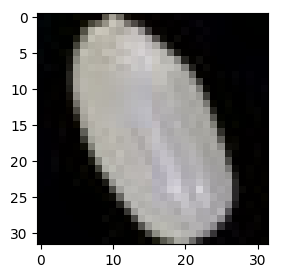

In [15]:
#let's visualize a single file
image = imread("image/train/proper/100.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [21]:
#lets load everything into memory first

#import training dataset
X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)



#import test dataset
X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(377, 32, 32, 3) (377,)
(20, 32, 32, 3) (20,)


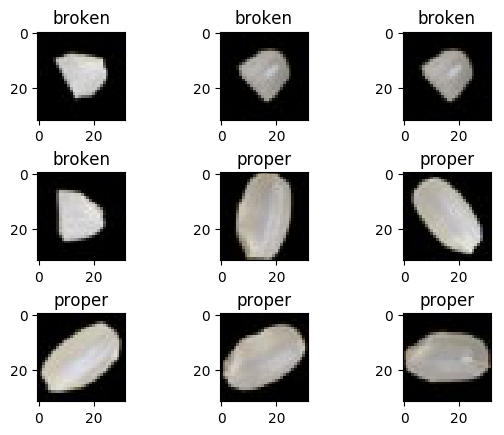

In [31]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#randomly show several images from the training dataset
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "proper"
    else:
        label = "broken"
    plt.title(label)
    plt.imshow(X_train[idx])

# Step 1 Manual Classification

Lets manually define the feature for classification. In this case, simply binarizing the image, extracting the area size of each image and then defining a threshold will do well. All of the image transformation and area measuring can be done with the functions of skimage and scipy.

(32, 32, 3)


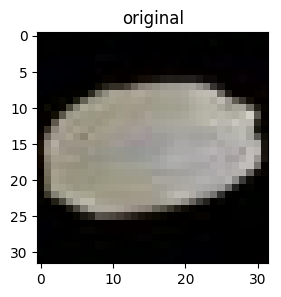

In [18]:
#Let's try it for one image
image = X_train[0]

#the original image
print(image.shape)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title("original")
plt.show()

(32, 32)


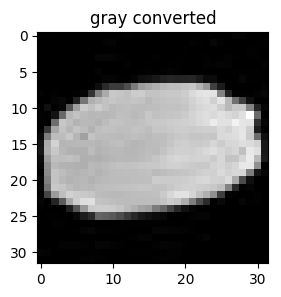

In [19]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.figure(figsize=(3,3))
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")
plt.show()

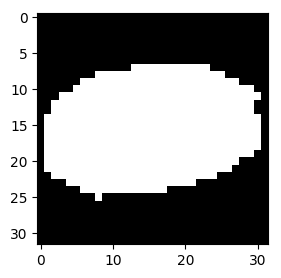

In [20]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.figure(figsize=(3,3))
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

In [0]:
label_im, nb_labels = ndimage.label(binary)
regionprops = measure.regionprops(label_im, intensity_image=gray)
regionprop = regionprops[0]

print(regionprop.area)
print(regionprop.major_axis_length)
print(regionprop.minor_axis_length)

265
18.960453228032428
18.350131979990607


In [0]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area = quantify_area(image)
print(area)

265


In [0]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

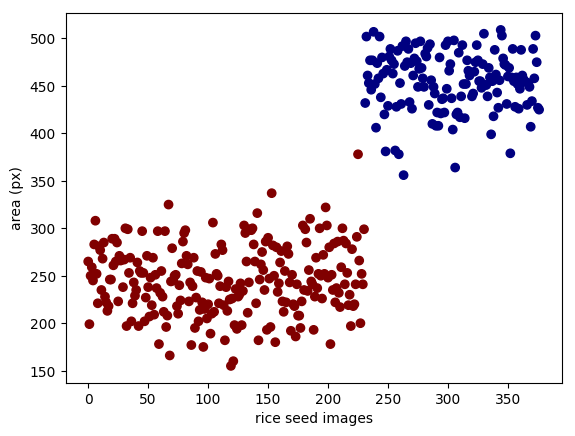

In [0]:
#check the calculated data area value of training dataset

plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

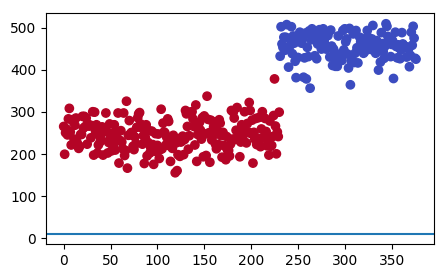

Confusion matrix, without normalization


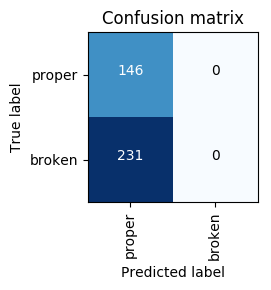

In [0]:
#define an area threshold that can seperate the two classes
area_threshold = 10

#classify whether the image is a proper seed or a broken seed according to the area_threshold value
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_train, train_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

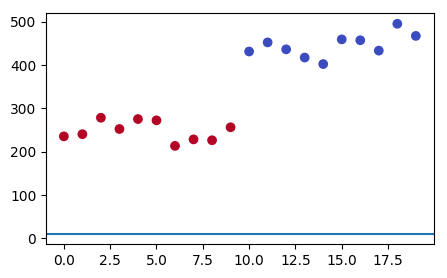

Confusion matrix, without normalization


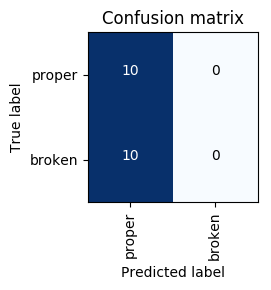

In [0]:
#evaluate it with the test dataset
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_test, test_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

correct label is:  1
predicted label is:  1


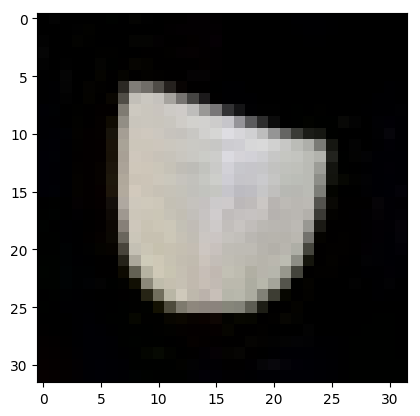

In [0]:
#build a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 5
image = X_test[n]
label = y_test[n]
area_threshold = 350
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)

# Step 2 Support Vector Machine Classification

We will next use Support Vector Machine (SVM) for Classification. Since SVM uses data greater than two dimension (features), we will add another metrics, major_axis_length of the region of interest.

In [0]:
def quantify_mal(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    mal = regionprop.major_axis_length
    return mal


X_train_mal = []
for image in X_train:
    mal = quantify_mal(image)
    X_train_mal.append(mal)

X_test_mal = []
for image in X_test:
    mal = quantify_mal(image)
    X_test_mal.append(mal)

In [0]:
#reshape data for svm input
X_train2 = np.array([[x,y] for x,y in zip(X_train_mal,X_train_area)])
X_test2 = np.array([[x,y] for x,y in zip(X_test_mal,X_test_area)])
#just concatenating the two data
print(X_train2[:5,:])

[[ 18.96045323 265.        ]
 [ 18.63536742 199.        ]
 [ 19.82159287 250.        ]
 [ 18.87849735 259.        ]
 [ 20.17793699 245.        ]]


In [0]:
#define linear support vector machine for defining the threshold
clf=svm.SVC(kernel="linear")
#train the classifier
clf.fit(X_train2,y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

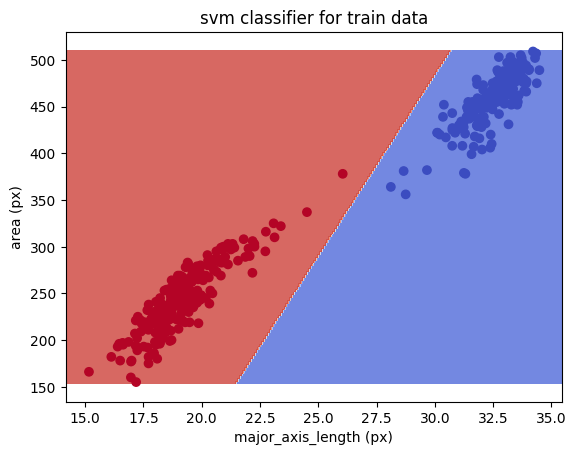

In [0]:
xx, yy = make_meshgrid(X_train2[:,0],X_train2[:,1],h=0.08)
plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train2[:,0],X_train2[:,1],c=y_train,cmap=plt.cm.coolwarm)
plt.title("svm classifier for train data")
plt.xlabel("major_axis_length (px)")
plt.ylabel("area (px)")
plt.show()

#Coordinates in the red region are classified broken seeds, while blue as proper shaped seeds

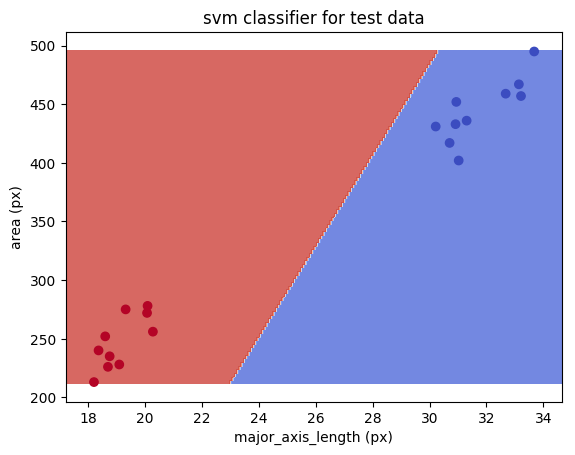

In [0]:
xx, yy = make_meshgrid(X_test2[:,0],X_test2[:,1],h=0.08)
plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_test2[:,0],X_test2[:,1],c=y_test,cmap=plt.cm.coolwarm)
plt.title("svm classifier for test data")
plt.xlabel("major_axis_length (px)")
plt.ylabel("area (px)")
plt.show()

correct label is:  1
predicted label is:  [1]


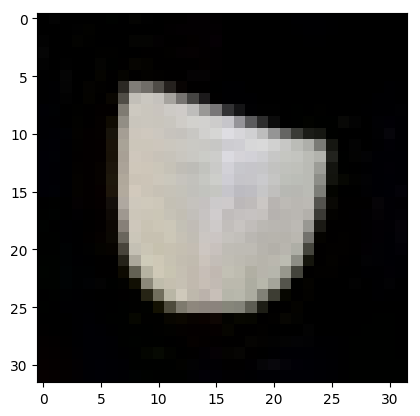

In [0]:
#construct a classifier function
def svm_classifier(clf,image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    result = clf.predict(np.array([1,area]).reshape(1, -1))
    return result
# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 5
image = X_test[n]
label = y_test[n]
prediction = svm_classifier(clf,image)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)

# Step 3 Deep learning (Convolutional Neural Network)

Finaly, we will use Convolutional Neural Network, a type of deep learning architecture that can handle images. By using CNN, we are freed from defining a suitable feature and only have to feed the images to the network. The CNN will find the most suitable features for classification

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Prepare Input Data

In [0]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, test_size=0.2, random_state=42)

## Model Construction

In [0]:
model = Sequential([
    layers.Conv2D(16, (3,3), input_shape=(32,32,3),name="conv1"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3,3),name="conv2"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64,name="fc1"),
    layers.Activation("relu"),
    layers.Dense(2,name="fc2"),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 32)          0         
__________

## Training

In [0]:
history = model.fit(x = X_train3, y = y_train3, batch_size=32, epochs= 10,validation_data=(X_valid3,y_valid3))

Train on 301 samples, validate on 76 samples
Epoch 1/10
301/301 [==============================] - 4s 14ms/step - loss: 0.5548 - acc: 0.6910 - val_loss: 0.4298 - val_acc: 0.9605
Epoch 2/10
301/301 [==============================] - 0s 322us/step - loss: 0.1893 - acc: 0.9834 - val_loss: 0.1902 - val_acc: 0.9474
Epoch 3/10
301/301 [==============================] - 0s 324us/step - loss: 0.0317 - acc: 0.9900 - val_loss: 0.0921 - val_acc: 0.9737
Epoch 4/10
301/301 [==============================] - 0s 326us/step - loss: 0.0230 - acc: 0.9900 - val_loss: 0.0970 - val_acc: 0.9868
Epoch 5/10
301/301 [==============================] - 0s 330us/step - loss: 0.0528 - acc: 0.9834 - val_loss: 0.1183 - val_acc: 0.9737
Epoch 6/10
301/301 [==============================] - 0s 332us/step - loss: 0.0198 - acc: 0.9934 - val_loss: 0.0587 - val_acc: 0.9868
Epoch 7/10
301/301 [==============================] - 0s 335us/step - loss: 0.0222 - acc: 0.9900 - val_loss: 0.1918 - val_acc: 0.9605
Epoch 8/10
301/301

## Visualizing Training Result

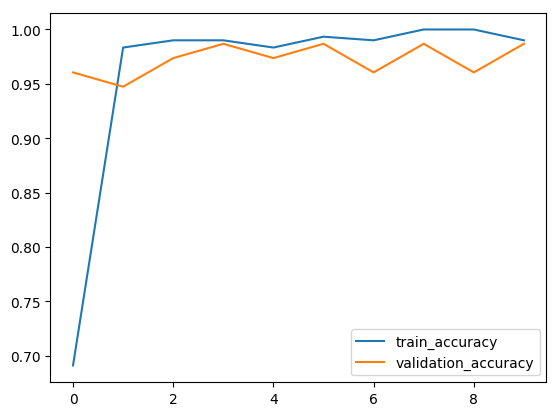

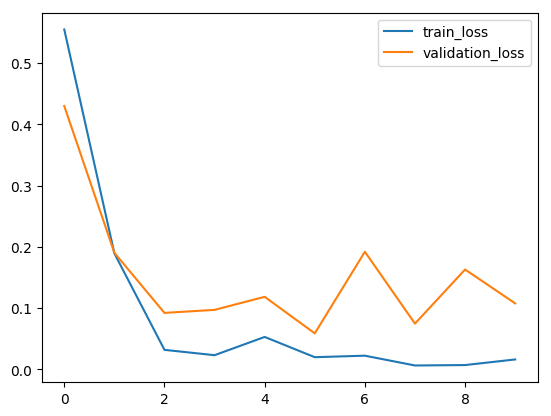

In [0]:
plt.plot(history.history["acc"],label="train_accuracy")
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"],label="validation_loss")
plt.legend()
plt.show()

## Use the model

In [0]:
print(X_train3.shape)

(301, 32, 32, 3)


In [0]:
n = 102
input_image = X_train3[n][np.newaxis,...]
print("label is: ", y_train3[n])

predictions = model.predict(input_image)
print("prediction is",predictions[0])

label is:  [1. 0.]
prediction is [9.9999750e-01 2.5576944e-06]


See that we just input image and get the results, while step 1 and step 2 required to construct feature(s) by our self.
This seed classification task was quite easy, but the complex the image gets, the harder to construct the most suitable feature gets.
That is when CNN shows its power.
See also the Yeast GFP protein localization tutorial for more complex image classification task.